# An analysis of the american political scene from a mediatic point of view

## Context

In the 21st century media coverage is a crucial factor for political figures. By studying the number of times a certain politician is quoted in media outlets (in our case New York Times), we can have a rough measure of how much interest does the media address to this politician. In our analysis we will study the evolution of the number of citations of some of the most important american politicians over the last few years and we will compare their evolution to the most important events in their carreer in order to see if there is any causation or correlation. We will then add some more analysis distinguishing the speakers (who quoted a certain politician) by religion, nationality and political party in order to have a better and fragmented view of the causal effects. In the end we will compare our work with Google Trends data in order to see if the conventional media outlets capture the online interest well.


## The data

We are provided with a compressed `.bz2` json file containing one row per quote. 
The `.json` has the following fields:

 - `quoteID`: Primary key of the quotation (format: "YYYY-MM-DD-{increasing int:06d}")
 - `quotation`: Text of the longest encountered original form of the quotation
 - `date`: Earliest occurrence date of any version of the quotation
 - `phase`: Corresponding phase of the data in which the quotation first occurred (A-E)
 - `probas`: Array representing the probabilities of each speaker having uttered the quotation.
      The probabilities across different occurrences of the same quotation are summed for
      each distinct candidate speaker and then normalized
      - `proba`: Probability for a given speaker
      - `speaker`: Most frequent surface form for a given speaker in the articles where the quotation occurred
 - `speaker`: Selected most likely speaker. This matches the the first speaker entry in `probas`
 - `qids`: Wikidata IDs of all aliases that match the selected speaker
 - `numOccurrences`: Number of time this quotation occurs in the articles
 - `urls`: List of links to the original articles containing the quotation 

In [1]:
# Imports we may need
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import numpy as np
import ujson as json
import bz2

### Load Quotes and Speaker Attributes

Load quotes related to Donald Trump.

In [4]:
df_Trump = pd.read_pickle("df_Trump_cleaned.pkl")

df_Trump

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
888,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],2015-09-16 05:44:37,1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E
1521,2015-12-22-031341,"I promise, I won't talk about Trump again,",Jeb Bush,[Q221997],2015-12-22 20:43:59,10,"[[Jeb Bush, 0.7816], [None, 0.1677], [Donald T...",[http://www.politico.com/story/2015/12/jeb-bus...,E
3257,2015-07-21-047379,I'm sure the Republicans are enjoying Mr. Trum...,President Barack Obama,[Q76],2015-07-21 15:18:20,205,"[[President Barack Obama, 0.6523], [None, 0.19...",[http://azdailysun.com/entertainment/televisio...,E
3819,2015-07-22-051864,"it in particular thrives on theater, which Tru...",Frank Bruni,[Q1443006],2015-07-22 13:33:11,1,"[[Frank Bruni, 0.8479], [None, 0.1246], [Donal...",[http://www.adweek.com/tvnewser/bob-kerrey-on-...,E
4261,2015-07-14-074352,it was appalling to hear Donald Trump describe...,Hillary Clinton,[Q6294],2015-07-14 08:40:17,1,"[[Hillary Clinton, 0.8129], [None, 0.1175], [B...",[http://www.bloomberg.com/politics/articles/20...,E
...,...,...,...,...,...,...,...,...,...
5243971,2020-04-05-029136,To say that I'm infuriated with the recent act...,Dwight Ball,[Q5318112],2020-04-05 23:11:52,1,"[[Dwight Ball, 0.6293], [None, 0.3336], [Justi...",[https://www.cbc.ca/news/politics/trudeau-will...,E
5243994,2020-02-05-103219,Trump offends and disrespects the Venezuelan p...,Jorge Arreaza,[Q6623799],2020-02-05 00:00:00,11,"[[Jorge Arreaza, 0.9164], [None, 0.0726], [Pre...",[https://www.rawstory.com/2020/02/imwithfred-t...,E
5243996,2020-03-13-071475,"Trump tried to mitigate the issue, saying it i...",Hassan Nasrallah,[Q181182],2020-03-13 22:15:06,1,"[[Hassan Nasrallah, 0.922], [None, 0.0741], [P...",[http://israelnationalnews.com/News/News.aspx/...,E
5243997,2020-03-15-037086,Trump's do-over approach -- he unlocked $50 bi...,Newt Gingrich,[Q182788],2020-03-15 00:00:00,40,"[[Newt Gingrich, 0.5146], [None, 0.3958], [Don...",[http://uspolitics.einnews.com/article/5120893...,E


Load the parquet dataframe with attributes of each author

In [5]:
speaker_attributes_updated = pd.read_parquet("data/speaker_attributes_updated.parquet")


In [6]:
speaker_attributes_updated

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Great Britain, United States of America]",[male],1395141751,None,W000178,"[politician, military officer, farmer, cartogr...",[independent politician],None,Q23,George Washington,"[1792 United States presidential election, 178...",item,[Episcopal Church]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[United Kingdom],[male],1395737157,[White British],None,"[playwright, screenwriter, novelist, children'...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Belgium],[male],1380367296,None,None,"[writer, lawyer, librarian, information scient...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,None,None,"[politician, motivational speaker, autobiograp...",[Republican Party],None,Q207,George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me..."
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Spain],[male],1391704596,None,None,[painter],None,None,Q297,Diego Velázquez,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055976,[Barker Howard],None,[United States of America],[male],1397399351,None,None,[politician],None,None,Q106406560,Barker B. Howard,None,item,None
9055977,[Charles Macomber],None,[United States of America],[male],1397399471,None,None,[politician],None,None,Q106406571,Charles H. Macomber,None,item,None
9055978,None,[+1848-04-01T00:00:00Z],None,[female],1397399751,None,None,None,None,None,Q106406588,Dina David,None,item,None
9055979,None,[+1899-03-18T00:00:00Z],None,[female],1397399799,None,None,None,None,None,Q106406593,Irma Dexinger,None,item,None


### Plot time series

We will plot the timeseries of the number of occurrences of quotes referring Hillary Clinton, and compare them with google trends in order to check if the two plots look similar or not

In [4]:
#Load file containing the occurence dates of each quote
Clinton_dataframe = pd.read_pickle("data/Clinton_with_dates.pkl")

In [12]:
Clinton_dataframe

,quoteID,quotation,speaker,qids,numOccurrences,probas,urls,phase,date
26,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",Bernie Sanders,[Q359442],1,"[[Bernie Sanders, 0.5395], [None, 0.3128], [Hi...",[http://examiner.com/article/bernie-sanders-sl...,E,[2015-10-25 14:12:35]
888,2015-09-16-006359,And I'm just pointing out the absurd on both s...,Kathleen Madigan,[Q6376814],1,"[[Kathleen Madigan, 0.8025], [None, 0.1975]]",[http://northjersey.com/arts-and-entertainment...,E,[2015-09-16 05:44:37]
6930,2015-10-22-051493,If [ Democratic presidential candidate former ...,Marco Rubio,[Q324546],1,"[[Marco Rubio, 0.93], [None, 0.0685], [Hillary...",[http://breitbart.com/video/2015/10/22/rubio-i...,E,[2015-10-22 20:04:16]
7374,2015-12-31-032035,I'm electable. I was elected in a purple state...,Jeb Bush,[Q221997],7,"[[Jeb Bush, 0.8392], [None, 0.0925], [Hillary ...",[http://www.postandcourier.com/article/2015123...,E,[2015-12-31 03:29:00]
9855,2015-11-12-104266,The incentive to invent episodes of discrimina...,Glenn Reynolds,[Q4392664],2,"[[Glenn Reynolds, 0.3454], [Ed Driscoll, 0.322...","[http://pjmedia.com/instapundit/218734/, http:...",E,[2015-11-12 00:00:00]
...,...,...,...,...,...,...,...,...,...
5222109,2020-03-06-025712,"I think that would have been a mistake, becaus...",Jennifer Palmieri,[Q18209402],1,"[[Jennifer Palmieri, 0.9117], [None, 0.056], [...",[https://www.rollingstone.com/politics/politic...,E,[2020-03-06 14:38:07]
5231803,2020-01-18-006266,"Chief Justice Rehnquist, when he presided over...",Dick Durbin,[Q434804],1,"[[Dick Durbin, 0.898], [None, 0.079], [Charlie...",[https://www.washingtonexaminer.com/news/impea...,E,[2020-01-18 05:01:08]
5235860,2020-01-06-061256,The main difference between Lindsey and his De...,David Woodard,[Q1177254],6,"[[David Woodard, 0.7544], [None, 0.1797], [Lin...",[http://chron.com/entertainment/article/How-Li...,E,[2020-01-06 00:00:00]
5235869,2020-04-09-052373,The model of Obama asking Bush and Clinton to ...,Bill Haslam,[Q862186],1,"[[Bill Haslam, 0.905], [None, 0.0837], [Barack...",[http://www.nytimes.com/2020/04/09/us/politics...,E,[2020-04-09 23:04:21]


In [5]:
#merge all dates in one single list to make it easier to plot

list_Clinton_dates = []

for date_list in Clinton_dataframe["date"].values: #we create a list containing all the dates of clinton quotes
    list_Clinton_dates = list_Clinton_dates + date_list

times_series_Clinton = pd.DataFrame(index = list_Clinton_dates) # we create a Df whose index are the dates 
times_series_Clinton.index = times_series_Clinton.index.map(lambda x: str(x)[:-9]) #we are not interested in the hour but just in the date, we remove the
#hour information from the index

Plot time series of quotes referring Hillary Clinton

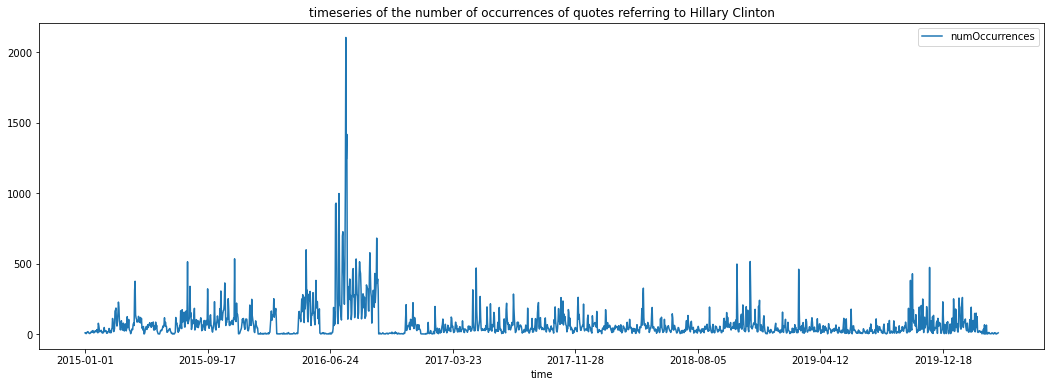

In [89]:
#Plot time series
times_series_Clinton["numOccurrences"] = 1
times_series_Clinton.groupby(by = times_series_Clinton.index).count().plot()
plt.rcParams["figure.figsize"] = (18,6) 
plt.title("timeseries of the number of occurrences of quotes referring to Hillary Clinton")
plt.xlabel("time")
plt.show()

In [90]:
#maximum number of occurences
times_series_Clinton.groupby(by = times_series_Clinton.index).count().max()

numOccurrences    2104
dtype: int64

As we can see the number of the maximum occurrences is 2104, which corresponds to the peak seen in the plot, let us see what is the date associated to that.

In [91]:
# date associated with maximum number of occurencer
times_series_Clinton.groupby(by = times_series_Clinton.index).count().sort_values('numOccurrences')

,numOccurrences
2017-01-12,1
2016-04-01,1
2016-04-03,1
2016-04-05,1
2016-06-04,1
...,...
2016-07-12,997
2016-07-25,1043
2016-07-27,1241
2016-07-28,1417


The date associated to the peak is 26/7/2016. Let us try to understand why. Since the date of the official nominee was 26 july of 2016, the peak simply reflects the interest of media on the new candidate.

### Timeseries before and after the election

In this section we want to plot the time series before and after the election. We will consider the time period of 3 month after and before the elections. In this case, since the election day for the United States presedensials of 2016 occur at 8 of November, we will consider the period from 8 of August of 2016 to 8 of February of 2017.

In [53]:
#select the time period of 3 month before and after the election day
times_series_Clinton_BA_election = pd.DataFrame()
times_series_Clinton_BA_election["date"] = times_series_Clinton.index
times_series_Clinton_BA_election = times_series_Clinton_BA_election[(times_series_Clinton_BA_election["date"] > '2016-08-08') & (times_series_Clinton_BA_election["date"] < '2017-02-08')]

times_series_Clinton_BA_election = pd.DataFrame(index = list(times_series_Clinton_BA_election["date"]))

Plot time series of quotes referring Hillary Clinton during the election period

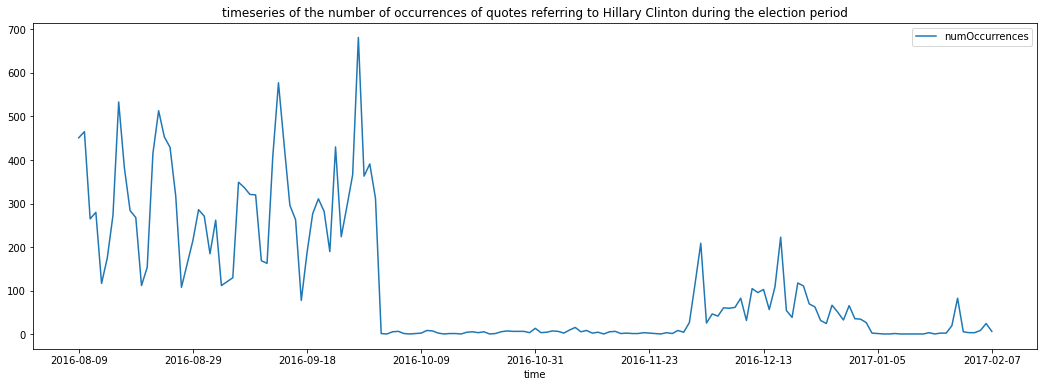

In [54]:
#Plot time series
times_series_Clinton_BA_election["numOccurrences"] = 1

times_series_Clinton_BA_election.groupby(by = times_series_Clinton_BA_election.index).count().plot()
plt.rcParams["figure.figsize"] = (18,6) 
plt.title("timeseries of the number of occurrences of quotes referring to Hillary Clinton during the election period")
plt.xlabel("time")
plt.show()

As we can see there is a huge decrease in the citations referred to Clinton in the period after the elections. While there is a huge number before. Indeed, the period before the election is simply debate period so lots of speaker are probably referring to her because of that. On the other hand, after the elections we assist to a huge decrease in popularity (from a mediatic point of view) due to the result in the elections.

### Compare with google trends

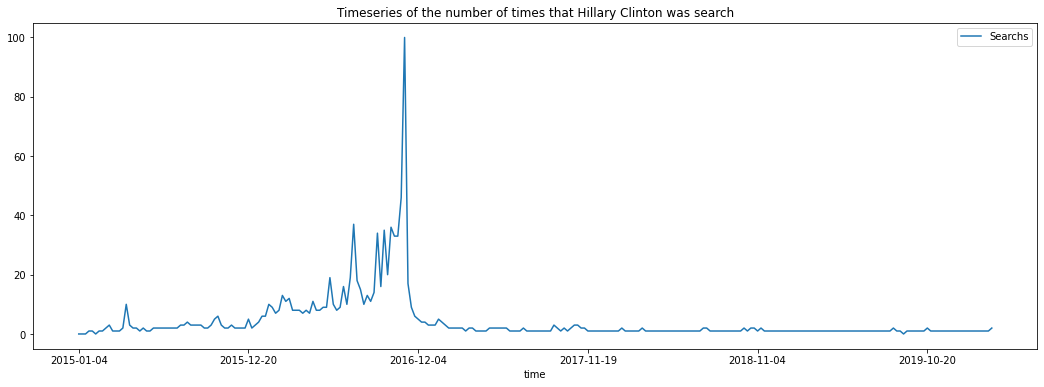

In [76]:
#plot google trends time series referred to the number of times Hillary Clinton was search
Clinton_google_trends = pd.read_csv('data/Clinton_google_trends.csv')

Clinton_google_trends.set_index("Week", inplace = True)
Clinton_google_trends.index.name = None

Clinton_google_trends.plot()
plt.rcParams["figure.figsize"] = (18,6) 
plt.title("Timeseries of the number of times that Hillary Clinton was search")
plt.xlabel("time")
plt.show()

As we can see in the plots of google trends and the time series of the number of occurrences of quotes related to Hillary Clinton, there is a spike on both plots in the year of 2016. This year match the United States presidencial elections year where Hillary Clinton was the presumptive nominee of the Democratic Party and running against Donald Trump.

Now, comparing the spikes of both plots, we see that the spike of number of occurences of quotes refering Hillary Clinton happens around the month of July and the spike of google trends happens arround November. A possible explanation for this deviation, is that we can assume that one of the main motivations for people to google a certain topic is because they read something about it, so it is plausible that the spike for the number of occurences of quotes related to a certain topic happens before the spike of google trends. In addition, probably people have googled Clinton during the period of elections which captured the global interest while the newspaper started speaking about Clinton before (because of debate periods).

### Relation between attribute and speakers

Our objective here is to realize if there is any relation between a specific attribute and the speakers of a certain politician

First to do this type of analisys, we load file with the authorID merged. This column contain the index of the speaker attributes file. This way we can search in constant time the speaker's attributes resulting in a more compact and general way to merge this values.

In [ ]:
#Load Clinton's speakers attributes file
Clinton_atributes = pd.read_pickle("data/Clinton_with_attributes.pkl")

Furthermore, we will need a function that extract a certain attribute of every speaker that quote a certain politician, so with this in mind we develop a function for that porpose.

In [51]:
def get_DataFrame_of_attribute(speakers_attribute_file,politician_with_attributes,attribute):
    """given a attribute return a dataframe with the attribute of each speaker of a certain politician"""

    #get the attribute of the speaker based on speaker attribute file
    Attribute_speaker_values = speakers_attribute_file.iloc[politician_with_attributes["authorId"]][attribute]

    df = pd.DataFrame()
    df[attribute] = Attribute_speaker_values

    #filter the speakers with no attribute assined
    df = df[pd.notna(df[attribute])]

    
    return df

We will need a function that return a dataframe properly fitted to do clear visualizations: 

In [52]:
def get_DataFrame_for_plot(df_raw,attribute, Relev_Num):
    """given a attribute and Relevant_Number return a dataframe with the relevant number of counts of speakers with a certain attribute"""
    list_Author_attribute = []

    for attribute_list in df_raw[attribute]:
        for attribute_value in attribute_list:
            list_Author_attribute.append(attribute_value)

    Author_attribute = pd.DataFrame(list_Author_attribute)
    Author_attribute_counts = Author_attribute.value_counts()

    #Consider relevant only the attribute with more than Relev_Num counts
    Author_attribute_values = Author_attribute_counts[Author_attribute_counts > Relev_Num]
    Author_attribute_values
    
    Author_attribute_plot_values = pd.DataFrame()
    Author_attribute_plot_values["counts"] = Author_attribute_values
    Author_attribute_plot_values = Author_attribute_plot_values.reset_index(level=0)
    Author_attribute_plot_values = Author_attribute_plot_values.rename(columns={0:attribute})
    
    return Author_attribute_values, Author_attribute_plot_values

### Relation between age and speakers 

Our objective here is to analise the age distribution of the Clinton's speakers

We get the age of each speaker based in their date of birth and then filter the outliers which we consider as ages larger than 100 years old. They are probably people speaking about a different Clinton (even if we have filtered the dataset we cannot be sure that all the quotes are referring to Hillary Clinton and not to another Clinton we have not removed even if we tried to remove the other most important Clinton).

age_speaker_values = speaker_attributes_updated.iloc[Clinton_atributes["authorId"]]["date_of_birth"].values
age_list = []
for date in age_speaker_values:
    if date is not None:
        age_list.append(int(date[0][1:5]))
                        
df_age = pd.DataFrame()
df_age["age"] = age_list
df_age["age"] = df_age["age"].transform(lambda x: 2021-x) 
age_list_filtered = df_age[df_age["age"]<100]["age"].values


Plot the age distribution of Clinton's speakers

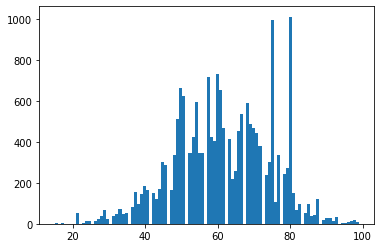

In [9]:
#plot the age distribution
plt.hist(age_list_filtered, bins= 100)
plt.show()

As we can see the majority of the speakers are around 60 years old but there is a peak around 75-80 too.

### Relation between ethnic group and speakers

Our objective here is realize which ethnic group are talking the most about a certain politician.

In [40]:
df_Clinton_ethnic = get_DataFrame_of_attribute(speaker_attributes_updated,Clinton_atributes,"ethnic_group")

Our final goal in this topic is to plot an histogram, so in order to have a better visualization we will just consider relevant the ethnic groups with more than 30 counts

In [46]:
Clinton_ethnic_values, Clinton_ethnic_plot_values = get_DataFrame_for_plot(df_Clinton_ethnic,"ethnic_group",30)
Clinton_ethnic_values

African Americans                   1227
Jewish people                       1144
Irish people                         357
Multiracial American                 299
Luo people of Kenya and Tanzania     284
Kenyan Americans                     284
white people                         138
Australians                          110
Italian American                     106
American Jews                         93
White Americans                       83
Scotch-Irish Americans                78
Czech American                        75
Scottish American                     68
Americans                             64
Croatian American                     60
Irish Americans                       45
Russians                              36
Armenian American                     34
Indian American                       31
dtype: int64

Plot the ethnic group distribution of Clinton's speakers

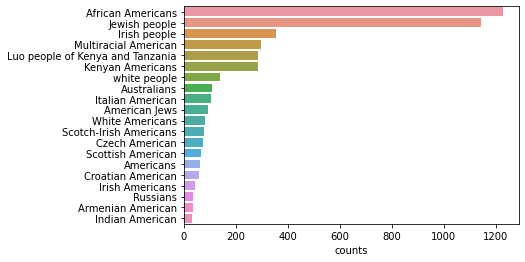

In [45]:
#histogram for the main ethnic groups of the speakers  
ethnic_Clinton_hist = sns.barplot(x=Clinton_ethnic_plot_values["counts"], y=Clinton_ethnic_plot_values["ethnic_group"].values, data=Clinton_ethnic_plot_values)
plt.show()

The majority of the speakers are African Americans and Jewish

### Relation between academic degreee and speakers

Our objective here is to realize if there is any relation between the academic degree and speaker of a certain politician

For instance lets take Clinton's speakers as our sample of study

In [47]:
df_Clinton_AD = get_DataFrame_of_attribute(speaker_attributes_updated,Clinton_atributes,"academic_degree")

Our final goal in this topic is to plot an histogram, so in order to have a better visualization we will just consider relevant the academic degrees with more than 5 counts

In [53]:
Clinton_AD_values, Clinton_AD_plot_values = get_DataFrame_for_plot(df_Clinton_AD,"academic_degree",5)
Clinton_AD_values

Bachelor of Arts                     3216
Juris Doctor                         1577
Bachelor of Science                   672
Master of Business Administration     385
Master of Science                     298
Doctor of Laws                        274
Doctor of Medicine                    251
bachelor's degree                     197
Doctor of Philosophy                  168
Master of Letters                      92
Candidate of Economic Sciences         35
Bachelor of Economics                  28
Master of Laws                         26
doctorate                              19
PhD in Law                             17
Doktor Nauk in Juridical Science       14
psychology                             12
doctor honoris causa                   10
Master of International Affairs         8
dtype: int64

Plot the academic degree distribution of Clinton's speakers

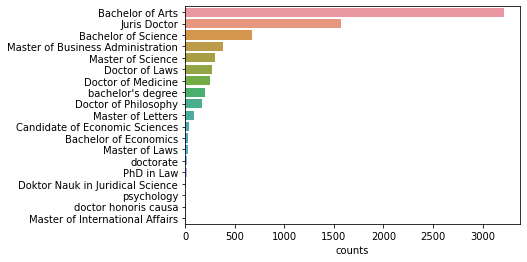

In [50]:
#histogram for the main academic degree of the speakers  
AD_Clinton_hist = sns.barplot(x=Clinton_AD_plot_values["counts"], y=Clinton_AD_plot_values["academic_degree"].values, data=Clinton_AD_plot_values)
plt.show()

The majority of the speaker have a bachelor of Arts

### Conclusion

In notebook Project2 we have proved the feasibility of the project and we have used the files created in the notebooks in the folder data_transformtion_notebooks to show some of the analysis we intend to do in Milestone 3 (plot times series, compare with google Trends, try to identify events by means of the time series,...). We have done it for Clinton even if we could have repeated the same analysis for Trump since we have Trump's data too. In milestone 3 we plan to redo the analysis in a more ordered way, probably we will use a chronological order to tell the story of the American political scene, starting from 2015 to 2020. Probably we will include more politicians such as Biden and Trump and we will try to indentify which events have influenced their mediatic visibility the most. Finally, as explained in the readme and as we have shown for Clinton, we plan to make some analysis on the different features of the speakers trying to compare the features of the speakers between the speakers of different politicians in order to understand if there are any noticeable difference which we can explain.